# Laboratory #04 : Corner detection and ORB

At the end of this laboratory, you would get familiarized with

*   Corner Detection using FAST and Harris Corners
*   ORB feature detectors and descriptors

**Remember this is a graded exercise.**

*   For every plot, make sure you provide appropriate titles, axis labels, legends, wherever applicable.
*   Create reusable functions where ever possible, so that the code could be reused at different places.
*   Use will have to mount your drive to access the images.

---

In [1]:
# Loading necessary libraries (Feel free to add new libraries if you need for any computation)

import numpy as np
from matplotlib import pyplot as plt
from skimage import color, data, feature, filters, io, transform
from pathlib import Path

The next cell contains some utility fuctions that will be used for the whole notebook

In [2]:
def plotImages(images, grid=(2, 2), figsize=(15, 9), **kwargs):
    f, ax = plt.subplots(grid[0], grid[1], figsize=figsize)
    for imageIdx, (title, image) in enumerate(images.items()):
        if grid[0] == 1:
            ax[imageIdx].set_title(title)
            ax[imageIdx].imshow(image, **kwargs)
            ax[imageIdx].axis('off')
        else:
            ax[imageIdx//grid[0]][imageIdx%grid[1]].set_title(title)
            ax[imageIdx//grid[0]][imageIdx%grid[1]].imshow(image, **kwargs)
            ax[imageIdx//grid[0]][imageIdx%grid[1]].axis('off')
    return f, ax

def loadImage(imagePath, gray=False):
    image = io.imread(imagePath)
    if gray and len(image.shape) > 2:
        image_gray = image
        if image.shape[2] == 4:
            image_gray = color.rgba2rgb(image_gray)
        image_gray = color.rgb2gray(image_gray)
        return image_gray
    return image

def imageToGray(image):
    image = image.copy()
    if len(image.shape) > 2:
        if image.shape[2] == 4:
            image = color.rgba2rgb(image)
        image = color.rgb2gray(image)
    return image

def plotDescriptors(images, grid=(2, 2), figsize=(15, 9), **kwargs):
    f, ax = plt.subplots(grid[0], grid[1], figsize=figsize)
    for imageIdx, (title, args) in enumerate(images.items()):
        if grid[0] == 1:
            ax[imageIdx].set_title(title)
            feature.plot_matches(ax[imageIdx], *args, **kwargs)
            ax[imageIdx].axis('off')
        else:
            ax[imageIdx//grid[1]][imageIdx%grid[1]].set_title(title)
            feature.plot_matches(ax[imageIdx//grid[1]][imageIdx%grid[1]], *args, **kwargs)
            ax[imageIdx//grid[1]][imageIdx%grid[1]].axis('off')
    return f, ax

# Corner Detection

**Exercise: #1**

*    Detect the corners in the image starbucks4.jpg. Use corner_fast to extract FAST corners for the given image and corner_peaks to find corners in the corner measure response image.
*   Show the original image, fast corners, peaks overlayed on the original image using matplotlib subplot.



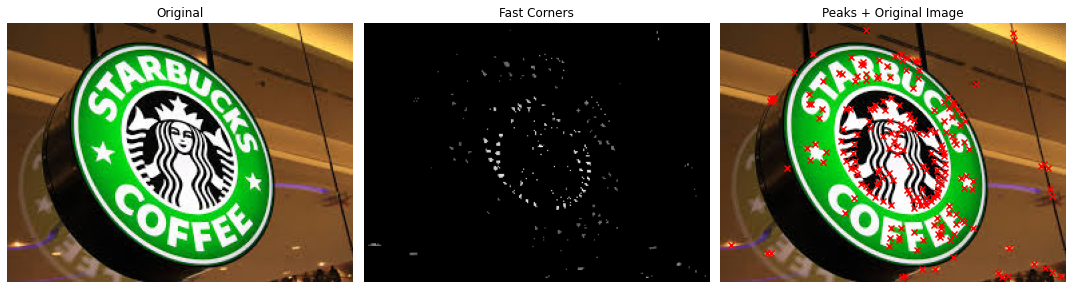

In [3]:
image = loadImage('images/starbucks/starbucks4.jpg')

gray_image = color.rgb2gray(image)
fast_corners = feature.corner_fast(gray_image)
corner_peaks = feature.corner_peaks(fast_corners)

images = {'Original': image,
        'Fast Corners': fast_corners,
        'Peaks + Original Image': image}

fig, axs = plotImages(images, grid=(1, 3), cmap='gray')
axs[2].scatter(corner_peaks[:, 1], corner_peaks[:, 0], color='r', marker='x')
plt.tight_layout()
plt.show()

*   Analyze and discuss the effect of different values of the parameter threshold in the corner_fast function.

**Solution**

The parameter `threshold` is the brightness difference tolerance between the candidate pixel and the circle of pixels at a distance `d` of it. Decreasing the threshold will yield more corners and vice-versa.

*   Repeat the experiment by replacing FAST corners with Harris corners.

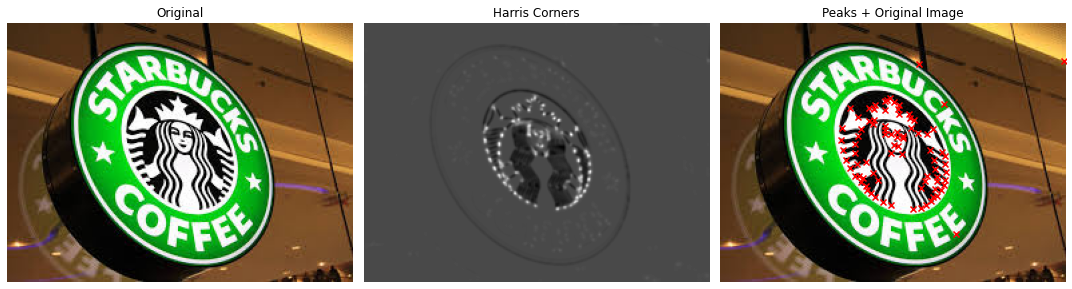

In [4]:
image = loadImage('images/starbucks/starbucks4.jpg')

gray_image = color.rgb2gray(image)
harris_corners = feature.corner_harris(gray_image)
corner_peaks = feature.corner_peaks(harris_corners, threshold_rel=0.1)

images = {'Original': image,
        'Harris Corners': harris_corners,
        'Peaks + Original Image': image}

fig, axs = plotImages(images, grid=(1, 3), cmap='gray')
axs[2].scatter(corner_peaks[:, 1], corner_peaks[:, 0], color='r', marker='x')
plt.tight_layout()
plt.show()

*   Do you find difference between both the techniques? If so, why and what difference do you observe?

**Solution**

Yes, there is a difference. Harris especially detects corners on which the contrast change is very noticeable. However, Harris will give priority to the corners in which there is a brightness change over the ones provinent from a color change or softer brightness difference. FAST is way more robust in this scenario than Harris, as it is able, for example, to easily detect the star points.

# ORB feature detector and binary descriptor

**Exercise #0: Compute ORB descriptors and find descriptors match**

*   Load 'astronaut' image from data module.
*   Convert the image to grayscale.
*   Create a copy of the image and rotate it by 180&deg; 



In [5]:
img1 = color.rgb2gray(data.astronaut())
img2 = transform.rotate(img1, 180)

*   Create an ORB feature detector with default parameters. *Hint: ORB feature detector is available in skimage.feature module.*



In [6]:
descriptor_extractor = feature.ORB(n_keypoints=200)

*   Use detect_and_extract function to detect features and extract descriptors.
*   Extract keypoints using descriptor_extractor.keypoints
*   Extract descriptors using descriptor_extractor.descriptors

In [7]:
descriptor_extractor.detect_and_extract(img1)
keypoints1 = descriptor_extractor.keypoints
descriptors1 = descriptor_extractor.descriptors

descriptor_extractor.detect_and_extract(img2)
keypoints2 = descriptor_extractor.keypoints
descriptors2 = descriptor_extractor.descriptors

*   Descriptors can be matched using match_descriptors function available in skimage.feature module
*   The matches can be plotted using the plot_matches function available in skimage.feature module

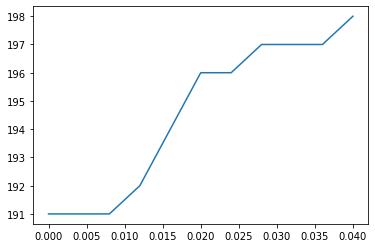

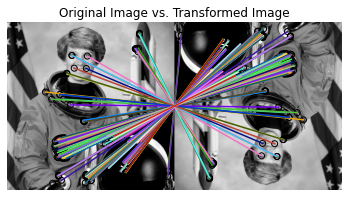

In [8]:
ratios = np.linspace(np.finfo(float).eps, .04, 11)
matches = list()
for ratio in ratios:
    matches12 = feature.match_descriptors(descriptors1, descriptors2, cross_check=True, max_ratio=ratio)
    matches.append(len(matches12))
plt.plot(ratios, matches)
plt.show()
feature.plot_matches(plt, img1, img2, keypoints1, keypoints2, matches12)
plt.axis('off')
plt.title("Original Image vs. Transformed Image")
plt.show()

**Exercise: #1**

*   Analyze and discuss the effect of different values of the parameter max_ratio in the match_descriptors function.

**Solution**
Max_ratio is the maximum ratio of distances between first and second closest descriptor in the second set of descriptors. This threshold is useful to filter ambiguous matches between the two descriptor sets.

However we do not find a meaningful change in the descriptors for the [0, 1). There are differences, but in the plot it can be seen that the number of matches range from 191 matches to 198 matches, which, at this scale, do not make a difference.

Because the images that we are comparing have the same information but flipped, the distances between the primary matches are much smaller than the distances between the secondary matches. Because of that the ratio for all matches is extremely small, only yielding some (but not significant) changes in the match detection. As tested, even with a max ratio of `np.finfo(float).eps` which is the smallest possible number represented in a numpy variable of type float, we still obtain 191 matches.

*   What do you infer from harris_k, n_scales, fast_n, fast_threshold parameters in ORB function?

**Solution**

**harris_k**  
The parameter harris_k corresponds to the k parameter in `skimage.feature.corner_harris`. It is the sensitivity factor to separate corners from edges. The smallest the parameters, the best detection of sharp corners.

**n_scales**  
Maximum number of times that the image is downsampled and blurred when detecting the corners. The bigger the value, the less accurate the prediction of the corner points. The contrast is also affected by the procedure.

**fast_n**  
The parameter fast_n corresponds to the n parameter in `skimage.feature.corner_fast`. It is the minimum number of consecutive pixels out of 16 pixels on the circle that should all be either brighter or darker with relation to the test-pixel.

**fast_threshold**  
The fast_threshold parameter corresponds to the threshold parameter in `feature.corner_fast`. It is the threshold used to decide whether the pixels on the circle are brighter, darker or similar with relation to the test-pixel.

**Exercise: #2**
*   Using the above example, create a function get_ORB, that takes two images as parameters and returns the keypoints of both images and descriptor matches

In [9]:
def get_ORB(img1, img2):
    descriptor_extractor = feature.ORB(n_keypoints=200)
    
    descriptor_extractor.detect_and_extract(img1)
    keypoints1 = descriptor_extractor.keypoints
    descriptors1 = descriptor_extractor.descriptors

    descriptor_extractor.detect_and_extract(img2)
    keypoints2 = descriptor_extractor.keypoints
    descriptors2 = descriptor_extractor.descriptors
    
    matches12 = feature.match_descriptors(descriptors1, descriptors2, cross_check=True)
    return (keypoints1, keypoints2, matches12)

*   With the function, detect the correspondences between the model image starbucks.jpg with the scene image starbucks4.jpg
*   Plot the matches between the two images.

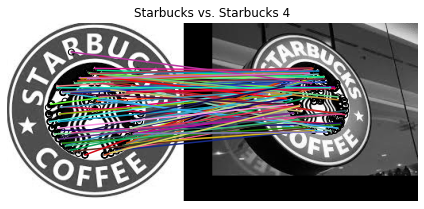

In [10]:
img1 = loadImage('images/starbucks/starbucks.jpg', gray=True)
img2 = loadImage('images/starbucks/starbucks4.jpg', gray=True)

keypoints1, keypoints2, matches12 = get_ORB(img1, img2)
feature.plot_matches(plt, img1, img2, keypoints1, keypoints2, matches12)
plt.axis('off')
plt.title("Starbucks vs. Starbucks 4")
plt.tight_layout()
plt.show()

**Exercise: #3**

*   Using "starbucks.jpg" image as a model, show its matches to all Starbucks images. 
*   Show the number of the matches for the pair as title for each plot.

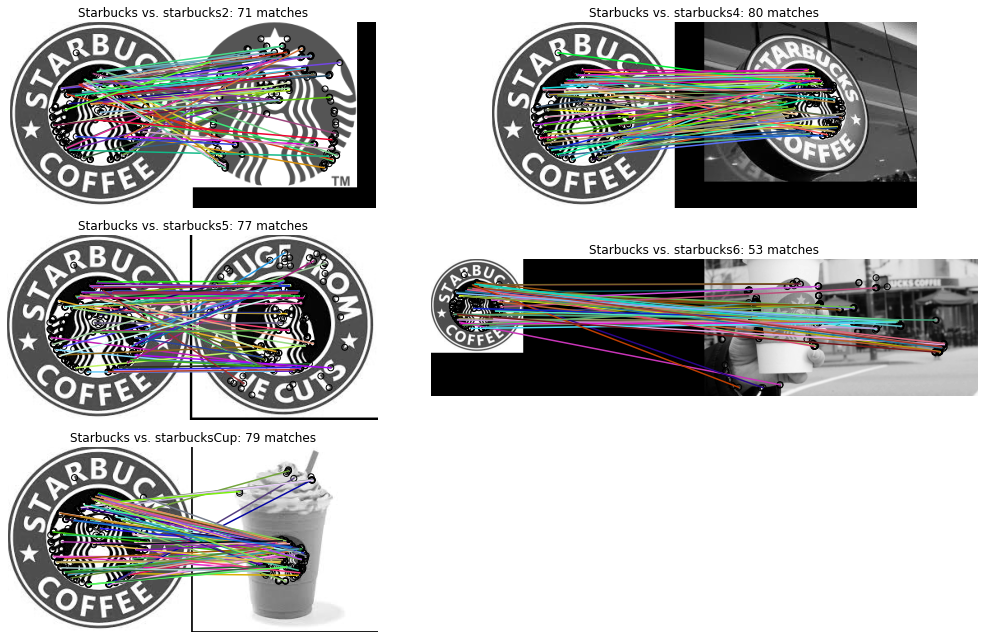

In [11]:
img1 = loadImage('images/starbucks/starbucks.jpg', gray=True)
starbucksImages = io.imread_collection('images/starbucks/starbucks[0-9C]*')
titles = sorted([x.stem for x in Path('images/starbucks/').glob('starbucks[0-9C]*')])

images = {}
for title, img2 in zip(titles, starbucksImages):
    img2_gray = imageToGray(img2)
    keypoints1, keypoints2, matches12 = get_ORB(img1, img2_gray)
    images[f"Starbucks vs. {title}: {len(matches12)} matches"] = (img1, img2_gray, keypoints1, keypoints2, matches12)

f, ax = plotDescriptors(images, grid=(int(np.ceil(len(starbucksImages)/2)), 2))
ax[2][1].axis('off')
f.tight_layout()
f.show()

*   Comment on the performance of the algorithm with respect to each image. When do you think the algorithm works better?

**Solution**

**starbucks2**  
The detections of the corners are good in both images, however, they are not matched as they should. We suppose it is because of the change in the backgound color from black to grey. And the rescaling also affects the detection.  
**starbucks4**  
The descriptors are matched quite better with respect to the previous plot. We can observe many paralel match lines going though both inner logos. This can be due to both images having similar contrasts around the corners and due to the second image being a tilted version (approximately) of the original one.  
**starbucks5**  
In the parts of the image that are being unaltered, the descriptors are matched quite successfully. However, because of the algorithm trying to find a match between descriptors when not filtered by the `max_ratio` parameter, it matches incorrectly the descriptors that are not present in the second image.   
**starbucks6**  
It does not work. We suspect that it does not because the ilumantion is way too different, and the logo being distorted, not transformed in a linear (rotation, scale, position) way.  
**starbucksCup**  
In this image, the descriptors are better matched than in the previous cup image. For instance, the crown corners are correcly matched. However, because of the scaling of the image and the contrast change in the logo section, the algorithm is not able to find all the matches successfully.  

The algorithm works better when the transformation is linear (rotation, scale, position). The worst transformation for the matching algorithm is the constrast changes, as it is not able to detect the descriptors correcly to begin with. If corners are in one image and not in the other, the algorithm tries to forcefully match each corner with the descriptor with the minimal distance of the other image, resulting in a false positive match. 

**Exercise: #4**

*   Repeate the experiment, by changing the orientation of the model image by rotating it and comparing it with its original version.
*   Create 8 orientations of the model image by rotating the image by 45&deg; (0, 45, 90, 135, 180, 225, 270, 315). *Hint: You can use the rotate() function from skimage.transform.*

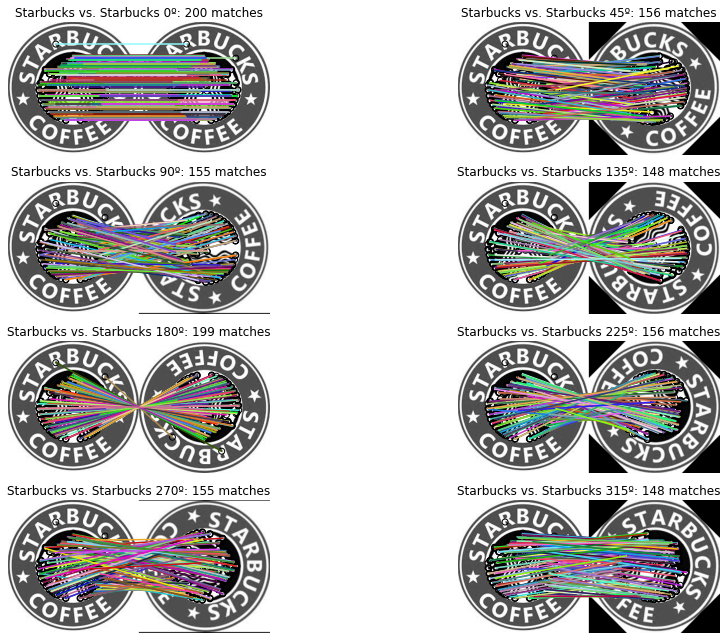

In [12]:
img1 = loadImage('images/starbucks/starbucks.jpg', gray=True)
starbucksImages = {'Starbucks 0º': transform.rotate(img1, 0),
                   'Starbucks 45º': transform.rotate(img1, 45),
                   'Starbucks 90º': transform.rotate(img1, 90),
                   'Starbucks 135º': transform.rotate(img1, 135),
                   'Starbucks 180º': transform.rotate(img1, 180),
                   'Starbucks 225º': transform.rotate(img1, 225),
                   'Starbucks 270º': transform.rotate(img1, 270),
                   'Starbucks 315º': transform.rotate(img1, 315)}

images = {}
for title, img2 in starbucksImages.items():
    keypoints1, keypoints2, matches12 = get_ORB(img1, img2)
    images[f"Starbucks vs. {title}: {len(matches12)} matches"] = (img1, img2, keypoints1, keypoints2, matches12)

f, ax = plotDescriptors(images, grid=(int(np.ceil(len(starbucksImages)/2)), 2))
ax[2][1].axis('off')
f.tight_layout()
f.show()

**Exercise: #5**

*   Repeat the experiment using Coco-cola images using cocacola_logo.png as the model image.
*   Does the same parameters used for Starbucks images work in this case? Or was it necessary to modify the ORB parameters?

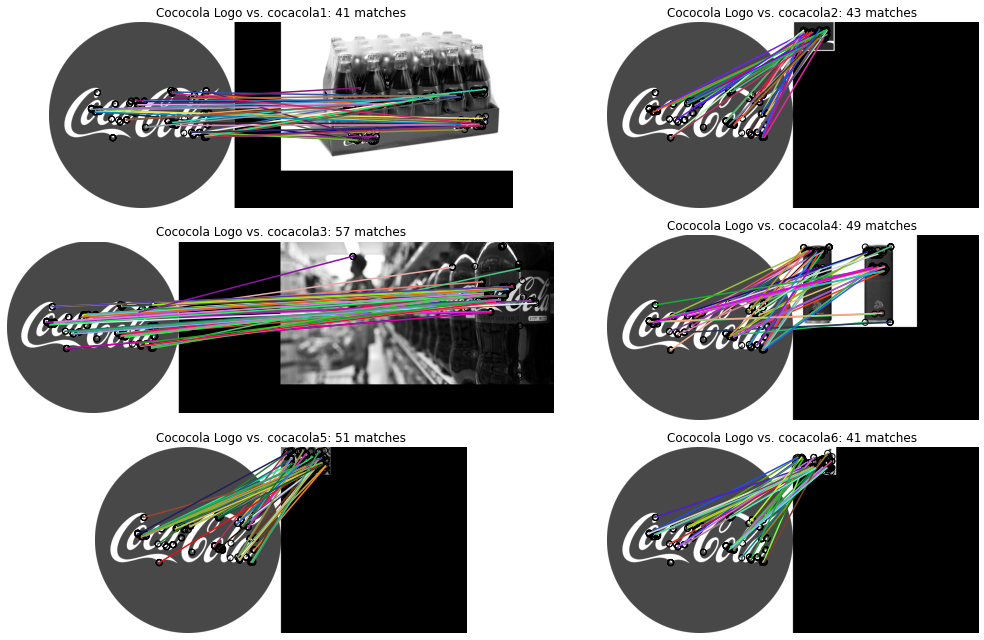

In [13]:
img1 = loadImage('images/cocacola/cocacola_logo.png', gray=True)
cocoColaImages = io.imread_collection('images/cocacola/cocacola[0-9]*')
titles = sorted([x.stem for x in Path('images/cocacola/').glob('cocacola[0-9]*')])

images = {}
for title, img2 in zip(titles, cocoColaImages):
    img2_gray = imageToGray(img2)
    keypoints1, keypoints2, matches12 = get_ORB(img1, img2_gray)
    images[f"Cococola Logo vs. {title}: {len(matches12)} matches"] = (img1, img2_gray, keypoints1, keypoints2, matches12)

f, ax = plotDescriptors(images, grid=(int(np.ceil(len(cocoColaImages)/2)), 2))
ax[2][1].axis('off')
f.tight_layout()
f.show()

**Exercise #6. Analysis of the applied techniques and results**

*   What are the advantages of ORB object detection compared with HOG object detector?

**Solution**

- ORB is much more robust to matching two images that have been rescaled or transformed (scale, rotation...), while HOG is much more dependant on the orientation of the image, yielding worse results.
- ORB provides less but more significant key points compared to HOG.
- With ORB matching without a sliding window can be done. the keypoints are automatically matched while with HOG it would be a manual task.
- ORB is quite more visual as it works on the original image while the HOG works on the histogram of gradients and it is less easy to visualize.

*   What would happen if you analyse an image that does not contain the Starbucks logo (as is the case of "edificio.jpg")?

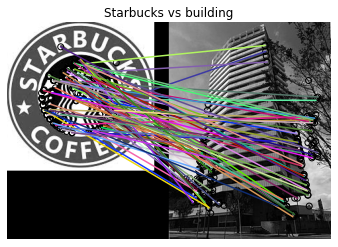

In [14]:
starBucksImage = loadImage('images/starbucks/starbucks.jpg', gray=True)
buildingImage = loadImage('images/edificio.jpg', gray=True)
keypoints1, keypoints2, matches12 = get_ORB(starBucksImage, buildingImage)
feature.plot_matches(plt, starBucksImage, buildingImage, keypoints1, keypoints2, matches12)
plt.axis('off')
plt.title("Starbucks vs building")
plt.show()

**solution**

The algorithm will try to find the best matches between the corners of both images. For instance, the building has black and white stripes that are being matched to the mermaid's hair and tail which also contains this pattern. Taking into account that the images are completely different, the algorithm does a good enough job of finding relatively similar points or descriptors.

*   What are the different ways of defining a quality measure for the correspondance between two images? (implementation of measures is not necessary)?

**Solution**

- Comparing the matches to a ground truth, precision and recall metrics can be obtained if the match is declared as a true positive, false positive, true negative and false negative when compared to the ground truth.
- If there is no rotation a meaure of paralelism between the lines of the matches between the images could be a suitable metric.
- Variation in the matches lines' length between the images. If we suppose two matches `sourcePixel1 -> targetPixel1` and `sourcePixel2 -> targetPixel2` it is expected that if the distance between the source Points is small, the distance of the target Points would be proportionally small. Because of that, the smaller the variance in the lengths of the matches will imply a better detection.

# Panorama Stitching (Not graded)

Image Mosaicing is a technique of combining multiple overlapping images into a single image.

*   A simple tutorial can be found in this notebook: 
*   https://github.com/scikit-image/skimage-tutorials/blob/master/lectures/adv3_panorama-stitching.ipynb


---

## **End of P4: Corner Detection and ORB**
Deadline for P4 submission in CampusVirtual is: **Thursday, the 29th of October, 2020**
